In [1]:
from ngsolve import *

from ngsolve.meshes import *
#from ngsolve.solvers import *
from ngsolve.webgui import Draw
from netgen.geom2d import unit_square

import numpy as np
import matplotlib.pyplot as plt

#from su2_yangmills import *
from lgt import *

import json

In [2]:
parameters = {}
#parameters["h"] = 0.05
parameters["h"] = 0.1
#parameters["h"] = 0.01
#parameters["h"] = 0.05
parameters["n"] = int(1/parameters["h"])
parameters["order"] = 6
#parameters["order"] = 2
#parameters["dt"] = 0.005
parameters["dt"] = 0.0001

In [3]:
ne=parameters["n"]
mesh = MakeStructured2DMesh(quads=True, nx=ne, ny=ne, periodic_x=True, periodic_y=True)
#mesh = MakeStructured2DMesh(quads=True, nx=ne, ny=ne, periodic_x=False, periodic_y=False)
#mesh = MakeStructured2DMesh(quads=False, nx=ne, ny=ne, periodic_x=False, periodic_y=False)
#mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [4]:
order=parameters["order"]
# for su2 charge
#fesC = L2(mesh, order=order, dgjumps=True)**3

# TODO: unable to access components of gridfunction - gives index error
#fesC = Periodic(L2(mesh, order=order)**3)
#fesG = Periodic(L2(mesh, order=0)**4)

# Lie algebra space
fesC = L2(mesh, order=order)**3

# quaternion space!
fesG = L2(mesh, order=0)**4

# upwind flux of current through faces
#fesjflux = FacetFESpace(mesh, order=0)**3


# parallel transport maps between neighbouring volumes, belonging to an oriented interface
#TODO: orientation is handled by a special CF
# quaternion space!
#fesU = FacetFESpace(mesh, order=0, dgjumps=True, dirichlet=".*")**4
fesU = FacetFESpace(mesh, order=0, dgjumps=True)**4

## Lie algebra space!
#fesA = FacetFESpace(mesh, order=0, dgjumps=True)**3


# define a global orientation of links
fesHd = HDiv(mesh, order=0)
gfor = GridFunction(fesHd)
#gfor = GridFunction(HDiv(mesh, order=0))
gfor.vec.data[:] = 1.
n = specialcf.normal(mesh.dim)

In [5]:
def gaussxy(mu, sigma2):
    return gaussx(mu[0], sigma2) * gaussy(mu[1], sigma2)

def gaussx(mu, sigma2):
    return 1./sqrt(2*pi*sigma2) * exp(-0.5/sigma2 *( (x-mu)*(x-mu)))

def gaussy(mu, sigma2):
    return 1./sqrt(2*pi*sigma2) * exp(-0.5/sigma2 *( (y-mu)*(y-mu)))

In [6]:
fesl2 = L2(mesh, order=0)
gfl2 = GridFunction(fesl2)
#el_num = 193
el_num = 75
gfl2.vec[el_num] =1.
Draw(gfl2, mesh)

gfhd = GridFunction(fesHd)
#e_num = 179
e_num = 158
gfhd.vec[e_num] = 1.

Draw(gfhd, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [7]:
# set the scenarios

# wind:

def rot_wind():
    return CF( (y-0.5,-(x-0.5)) ) 

def x_wind():
    return CF( (1,0) )

def y_wind():
    return CF( (0,1) )

def mx_wind():
    return CF( (-1,0) )

def xy_wind():
    return CF( (1,1) )


#rot_wind()
#tend = 5.00 # numerical dispersion and oscillations kick in
tend_rot_wind = 6.3 # one rotation
#tend = 3.


#mxmy_wind()
#tend = 5.00 
tend_mxmy_wind = 0.3


#???
#tend_x_wind = 0.2
tend_x_wind = 0.4

# charge distribution:

mu = [0.5,0.3]
mu_l = [0.3,0.5]
mu_c = [0.5,0.5]
sigma2 = 0.01

def rho_center(gfrho):
    gfrho.Set( CF( (gaussxy(mu_c, sigma2), 0, 0) ) )
    return gfrho

def rho_d(gfrho):
    gfrho.Set( CF( (gaussxy(mu, sigma2), 0, 0) ) )
    return gfrho

def rho_l(gfrho):
    gfrho.Set( CF( (gaussxy(mu_l, sigma2), 0, 0) ) )
    return gfrho


# background gauge links:

#e_num=220
#e_num=10
e_num=158

q_theta = 0.1*pi
theta =0.
phi=0.


#ur
el_num = 75

#d
#el_num = 88

#r
#el_num = 177
#el_num = 193


scenario = {}

scenario["wind"] =  rot_wind
#scenario["wind"] =  x_wind
#scenario["wind"] =  xy_wind

#scenario["rho"] = rho_d
#scenario["rho"] = rho_center
scenario["rho"] = rho_l

scenario["tend"] = tend_rot_wind
#scenario["tend"] = 0.5
#scenario["tend"] = tend_x_wind

# scenario 1: trivial links
scenario["gfU"] = lambda _U: trivial_gauge(_U)
# scenario 2: single link
#scenario["gfU"] = lambda _U: single_link(_U, mesh, e_num, qtheta=0.25*pi, theta=0., phi=0.)

# scenario 1,2: trivial links
#scenario["gauge"] = trivial_gauge

# scenario 3: single element gauge
scenario["gauge"] = lambda _gfg: single_el_gauge(_gfg, el_num, qtheta=-0.25*pi, theta=0., phi=0.)
#scenario["gauge"] = lambda _gfg: single_el_gauge(_gfg, el_num, qtheta=0.35*pi, theta=0., phi=0.)
#scenario["gauge"] = lambda _gfg: single_el_gauge(_gfg, el_num, qtheta=0.5*pi, theta=0., phi=0.)

#scenario["name"] = "diag_singleU"
#scenario["name"] = "cw_singleU"
#scenario["name"] = "x_trivial"
#scenario["name"] = "xy_trivial"
#scenario["name"] = "rot_single"
scenario["name"] = "rot_elgauge"

In [8]:
folder_name = f"{scenario['name']}"  
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
parfolder_name = f"{folder_name}/{parameters['n']}_order{parameters['order']}_dt{parameters['dt']}"  
if not os.path.exists(parfolder_name):
    os.makedirs(parfolder_name)

In [9]:
# set wind
cfwind = scenario["wind"]()

hcwind = GridFunction( HCurl(mesh,order=1) )
hcwind.Set(cfwind)
Draw(cfwind, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [10]:
#set gauge links

gfU = GridFunction(fesU)

#set_gfU_const(gfU, qtheta=0.1*pi, theta = 0., phi=0.)
#set_gfU_link(gfU, enum=220, qtheta=0.1*pi, theta = 0., phi=0.)

gfU = scenario["gfU"](gfU)
#scenario["gfU"](gfU)
#gfU = trivial_gauge(gfU)
#gfU = single_link(gfU, mesh, e_num, qtheta=0.25*pi, theta=0., phi=0.)



# the orientation of gauge links coincides with that of facet normal vectors!
# the gauge links need to take this into account 
# convention: gfU links go along global normal vector
# gfUglob links point out of the element
# TODO: ist this consistent with C++ code, where orientation is based on vertex numbering?
gfUglob = IfPos(gfor*n, gfU, qconjCF(gfU))



# for the current coupling term J*A at facets
# the "gauge fields" direction needs to be taken into account

#gfA = GridFunction(fesA)

#gfA.Set( (qlogCF(gfU))[1:] )

# similar orientation issue with gfU/gfUglob
#gfAglob = IfPos(gfor*n, gfA, -1.*gfA)

In [11]:
# set charge density

gfrho = GridFunction(fesC)

gfrho = scenario["rho"](gfrho)



#Draw(Norm(gfrho), mesh)
#Draw(gfrho.components[0], mesh)
Draw(gfrho, mesh)
#print(Integrate(Norm(gfrho), mesh))

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [12]:
# apply gauge transformation
gfg = GridFunction(fesG)

# gfg.components[0].vec.data[:] = 1.
# gfg.components[1].vec.data[:] = 0.
# gfg.components[2].vec.data[:] = 0.
# gfg.components[3].vec.data[:] = 0.

gfg = scenario["gauge"](gfg)

print("before gauging")

gfUviz = GridFunction(fesHd)

#gfUviz.vec.data[:] = gfU.components[0].vec[:]
gfUviz.vec.data[:] = parameters["h"]*gfU.components[0].vec[:]
Draw(gfUviz, mesh)

Draw(gfrho, mesh)



print("after gauging")
gauge_rho(gfrho, gfg)
gauge_gfU(gfU, gfg, fesU)

#gfUviz.vec.data[:] = gfU.components[0].vec[:]
gfUviz.vec.data[:] = parameters["h"]*gfU.components[0].vec[:]
#Draw(gfUviz, mesh)

Draw(gfrho, mesh)

before gauging


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

after gauging


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [13]:
#dt = 0.00001
#dt = 0.001

tend = scenario["tend"]
dt = parameters["dt"]
n_steps = int(tend/dt)
print(n_steps)

62999


In [14]:
conv = BilinearForm(fesC, nonassemble=True)
c,cp = fesC.TnT()
#c,cp = fesC.TnT()


# convection inside elements
#j = OuterProduct(c, cfwind)
#gradcp = grad(cp)
#conv += InnerProduct(j, gradcp)*dx

#conv += -InnerProduct(OuterProduct(c, cfwind), grad(cp))*dx
conv += -InnerProduct(OuterProduct(c, hcwind), grad(cp))*dx

# convection term between elements
# DG upwinding while respecting parallel transport
# TODO: check if consistent with LGT convention
# U * c * U^{-1}
n = specialcf.normal(mesh.dim)
#c_up = IfPos(cfwind*n, c, vec_from_q(qmulCF(qmulCF(qconjCF(gfUglob), q_from_vecCF(c.Other())), gfUglob)) )
c_up = IfPos(cfwind*n, c, ptransport_color(c.Other(), gfUglob, forward=False) )

conv += cfwind*n*c_up*cp*dx(element_boundary=True)
#conv += cfwind*n*c_up*cp*dx(skeleton=True)


mc = BilinearForm(fesC)
mc += InnerProduct(c,cp)*dx
mc.Assemble()
mcmat = mc.mat
mcmatinv = mcmat.Inverse(fesC.FreeDofs())

In [15]:
fesjviz = HDiv(mesh, order=0, dgjumps=True)**3
gfjviz = GridFunction(fesjviz)

def update_jviz(gfjviz):
    gfjflux = calc_upwind_colorflux(gfrho, cfwind, gfUglob, mesh, glob_or=True)
    gfjviz.vec.data = gfjflux.vec

    
update_jviz(gfjviz)
Draw(gfjviz, mesh)
#Draw(gfjviz, mesh, min=-5., max=5.)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [16]:
# # reverse engineer the flux to visualize it

# gfjflux = calc_upwind_colorflux(gfrho, cfwind, glob_or=True)

# fesj = HDiv(mesh, order=0, dgjumps=True)**3

# jviz = fesj.TrialFunction()
# jvizp = fesj.TestFunction()

# Mj = BilinearForm(fesj)
# fj = BilinearForm(fesj)

# Mj += InnerProduct(jviz,jvizp)*dx
# fj += InnerProduct(gfjflux,jvizp*n)*dx(skeleton=True)

# Mj.Assemble()
# #fj.Assemble()

# gfjviz = GridFunction(fesj)
# gfjvec = GridFunction(fesj)
# jvec1 = gfjvec.vec.CreateVector()
# jvec2 = gfjvec.vec.CreateVector()

# fj.Apply(jvec1, jvec2)

# Mjmatinv = Mj.mat.Inverse()

# #gfjviz = (Mj.mat.Inverse())*fj.vec
# gfjviz = Mjmatinv*jvec2

# Draw(gfjviz, mesh)
# Draw(gfrho, mesh)

In [17]:
tempC = gfrho.vec.CreateVector()
newgfrho = GridFunction(fesC)

def timestep_charge(gfC, newgfC):
    newgfC.vec.data[:] = gfC.vec[:]
    conv.Apply(gfC.vec, tempC)
    newgfC.vec.data[:] += -1.*dt*mcmatinv* tempC
    #newgfC.vec.data[:] += dt*mcmatinv* tempC
    gfC.vec.data[:] = newgfC.vec[:]

In [18]:
gfCscenes = []
gfCscenes.append(Draw(gfrho[0], mesh))
gfCscenes.append(Draw(gfrho[1], mesh))
gfCscenes.append(Draw(gfrho[2], mesh))

gfCscenes.append(Draw(Norm(gfrho), mesh))
gfCscenes.append(Draw(gfjviz, mesh))

Cs = []


if not os.path.exists(f"{parfolder_name}/vtk"):
    os.makedirs(f"{parfolder_name}/vtk")
vtk = VTKOutput(mesh, coefs=[gfrho], names=["rho"],filename=f"{parfolder_name}/vtk/vtk_snap",subdivision=2)

viz_steps = 10

#nt_snaps = list(range(0,n_steps,int(n_steps/viz_steps)))
nt_snaps = [ i*int(n_steps/viz_steps) for i in range(viz_steps) ]
#nt_snaps = list(range(n_steps))

#print(nt_snaps)


t = 0.
vtk.Do(time=t)
for i in range(n_steps):
    timestep_charge(gfrho, newgfrho)
    update_jviz(gfjviz)
    
    t += dt
    
    if i % viz_steps == 0:
        for scene in gfCscenes:
            scene.Redraw()
            
    if (i in nt_snaps):
        vtk.Do(time=t)

    _c = Integrate(Norm(gfrho), mesh)
    Cs.append(_c)
    #t += dt
        
    print ("\r", f"timestep:{i}, t:{t} charge:{_c}", end="")
    #input()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

 timestep:2015, t:0.20159999999999412 charge:0.9984374662154277

no more timer available (biform_from_py), reusing last one


 timestep:62998, t:6.299899999998656 charge:1.00009591051457217

In [19]:
Integrate(Norm(gfrho), mesh)

1.0000959105145721

ValueError: x and y must have same first dimension, but have shapes (62998,) and (62999,)

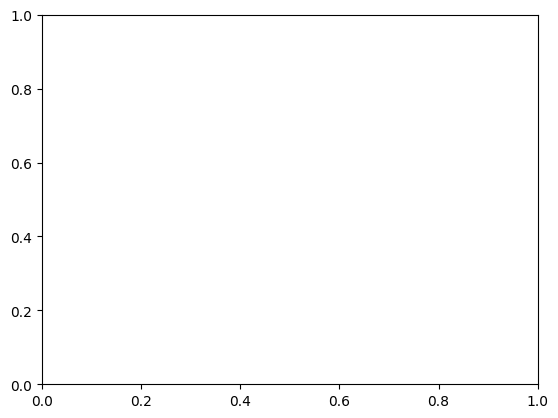

In [20]:
with open(f"{parfolder_name}/Cs.json", "w") as f:
    json.dump(Cs, f, indent=2)

plt.plot(np.arange(0.,t-dt,dt), Cs, label=r"$\rho$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\rho$")
plt.savefig(f"{parfolder_name}/Cs.png")
#plt.legend()